# Cardiomyocite

In [1]:
using Pkg
Pkg.activate("../")
using CairoMakie
using Random
using Distributions
using StatsBase
using LinearAlgebra
using DSP

  Activating project at `~/git/projects/perspective_heart_and_brain`


### Example ECG data (if we manage to read in with julia)
taken from https://www.physionet.org/content/autonomic-aging-cardiovascular/1.0.0/


In [2]:
using DelimitedFiles
# wfdb format consists of a header file (hea) and a data file (dat)
base="../data/Schuhmann_Baer_PhysioNet_2021/0001"
# read header file line by line
hea = readlines(base * ".hea")
println(hea[1])
record = Dict()
# first line is general information, split the string
elements = split(hea[1])
record["name"] = elements[1]
record["n_sig"] = parse(Int, elements[2])
record["fs"]  = parse(Int, elements[3])
record["sig_len"] = parse(Int, elements[4])
# remaining rows describe signals
record["sig_name"] = Vector{String}(undef, record["n_sig"])
record["filename"] = Vector{String}(undef, record["n_sig"])
record["init_value"] = Vector{Int}(undef, record["n_sig"])
record["baseline"] = Vector{Float64}(undef, record["n_sig"])
record["adc_gain"] = Vector{Float64}(undef, record["n_sig"])
for i in 2:length(hea)
    elements = split(hea[i])
    record["filename"][i-1] = elements[1]
    dac = elements[3]
    baseline, _dac = split(dac, "(")
    record["adc_gain"][i-1] = parse(Float64, baseline)
    gain, _ = split(_dac, ")")
    record["baseline"][i-1] = parse(Float64, gain)
    record["init_value"][i-1] = parse(Int, elements[6])
    record["sig_name"][i-1] = elements[8]
end
# extract information from header file
println(record["filename"])
println(record["init_value"])
println(record["sig_name"])

# based on header read in the data file
samples = zeros(UInt16, record["n_sig"], record["sig_len"])
println(size(samples))
ne = 0;
open(base * ".dat", "r") do io
    for j in 1:record["sig_len"]
        for i in 1:record["n_sig"]
            samples[i,j] = read(io, UInt16)
        end
    end
end
time = 0:1/record["fs"]:(record["sig_len"]-1)/record["fs"]


0001 3 1000 900401
["0001.dat", "0001.dat", "0001.dat"]
[5833, -15951, -20028]
["0", "0", "0"]
(3, 900401)


0.0:0.001:900.4

In [4]:
# DAC (digital to analog conversion) to obtain the "p_signal" (c.f. https://github.com/MIT-LCP/wfdb-python/blob/main/wfdb/io/_signal.py#L590)
# `digital - baseline / adc_gain = physical`
d_signal = (Float64.(samples) .- record["baseline"]) ./ record["adc_gain"]
samples = d_signal

3×900401 Matrix{Float64}:
   0.186327    0.189795    0.198486    0.203709  …   -0.0207648   -0.046282
   1.2412      1.22788     1.21978     1.22152        1.3952       1.24177
 183.269     183.252     183.235     183.219        153.163      152.647

In [5]:
mask = 0.4 .< time .< 2.4;
mtime = time[mask]
msamples = samples[:, mask]

3×1999 Matrix{Float64}:
   0.204309    0.202553    0.209532  …    0.236205    0.248964    0.255343
   1.22557     1.22324     1.23946        1.23541     1.23887     1.22152
 189.801     189.77      189.738        187.188     187.164     187.141

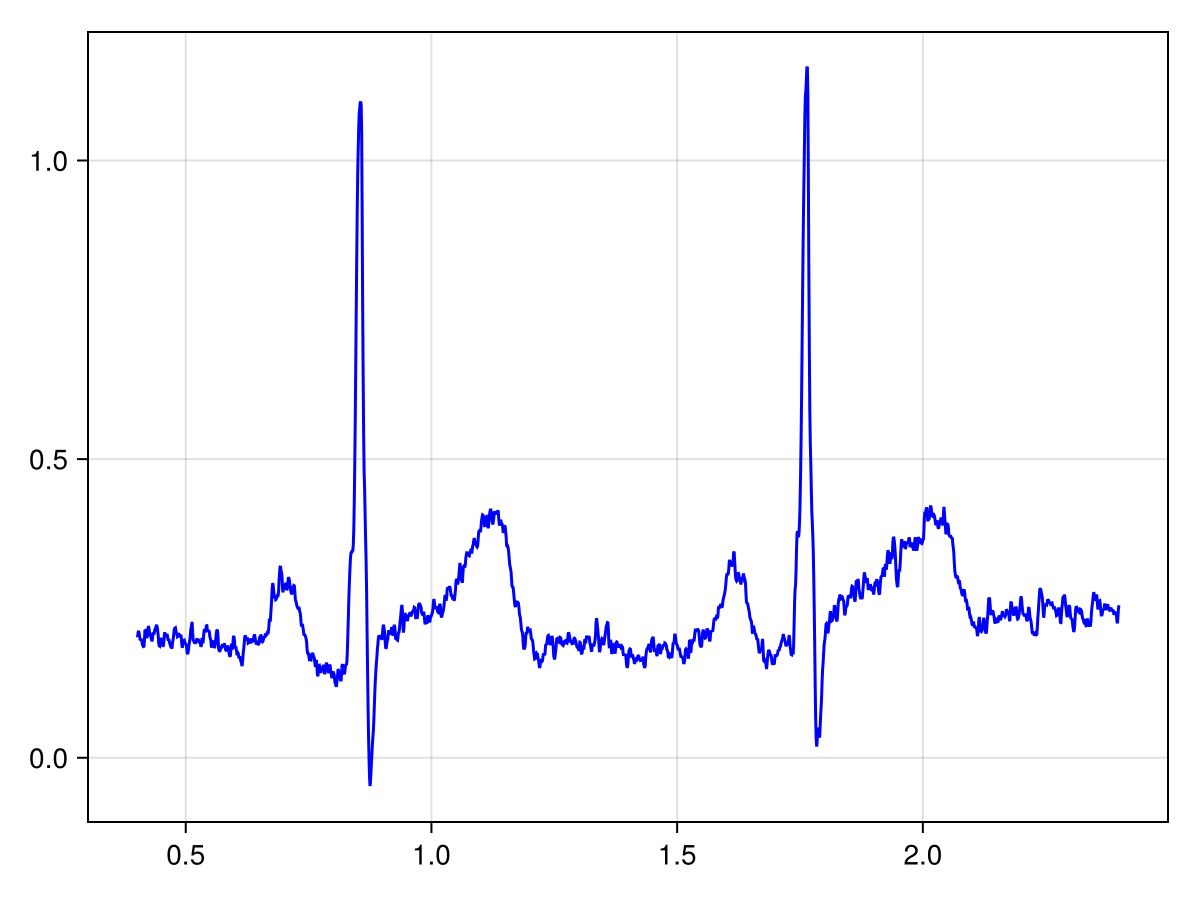

In [26]:
fig = Figure()
ax = Axis(fig[1, 1])
lines = lines!(ax, mtime, msamples[1, :], color = :blue)
fig

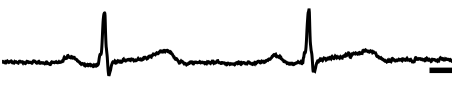

In [28]:
# plot the data (consistent with ecg_data from wfdb packages in python)
fig = Figure(size = (8*cm, 1.5*cm), fontsize=10, figure_padding = 1, backgroundcolor = :transparent)
ax = Axis(fig[1,1]; xgridvisible = false, ygridvisible = false, backgroundcolor = :transparent)
hidedecorations!(ax)
hidespines!(ax)
lines!(ax, mtime.-0.4, msamples[1,:], color = :black)
xlims!(ax, (0, 2.0))
ylims!(ax, (-0.2, 1.3)) # 1.5mV
# include a scale for the time
ts = [1.9, 2.0]
band!(ts, ones(length(ts))*0, ones(length(ts))*0.1, color = colorant"black")
# save as pdf with transparent background
save("../figures/ecg_example.pdf", fig, pt_per_unit = 1)
fig

### Model for action potentials during ECG

- cell-cell transmission delay is O($100 \mu s$) [https://academic.oup.com/cardiovascres/article/62/2/309/316416]
- heart cycle: https://en.wikipedia.org/wiki/
- dog, helpful?: https://www.ahajournals.org/doi/pdf/10.1161/01.RES.62.2.395

#### Stages 
- SA-Node at time t_0
- Atrial wave propagation from SA to AV for 50ms
- Delay at AV node for 100ms
- AV node to His-bundle for 25ms
- His-bundle to Purkinje fibers for 50ms
- Ventricle wave propagation 300-400ms (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7328879/) - check?

In [7]:
"""
    successive_cardiomyocite_action_potentials(times_SA, action_potential_duractions)

Create exemplary action potentials for the heart. The action potentials are created for the sinoatrial node (SA), the atrial wave, the atrioventricular node (AV), the His bundle, the Purkinje fibers, and the ventricular wave. The action potentials are created at the given times and have the given durations.

# Arguments
- `times_SA::Vector{Float64}`: The times at which the SA action potentials start.
- `action_potential_duractions::Dict{String, Float64}`: The durations of the action potentials in different compartments

# Returns
- `aps::Vector{}: Vector of tuples with (time, index, type) of exemmplary cells
"""
function successive_cardiomyocite_action_potentials(t0s;
    delay = 0.1/1e3, # s
    time_atrial_wave = 50/1e3, # s
    delay_AV_node = 100/1e3, # s
    time_AV_to_HIS = 25 /1e3, # s
    time_HIS_to_Purkinje = 50/1e3, # s (maybe this includes the Purkinje that start ventrical wave)
    time_ventrical_wave = 50 /1e3, # s CHECK (electrical signal likely during full action potential, so 350-300 = 50ms)
    ) 
    function next!(state)
        state[1] += delay
        state[2] += 1
    end

    aps = []
    for t0 in t0s
        println(t0)
        state = [t0, 1, "SA"]
        push!(aps, copy(state))

        # Atrial wave
        state[3] = "Atrial"
        t_ref = t0
        while state[1] < t_ref + time_atrial_wave
            next!(state)
            push!(aps, copy(state))
        end

        # AV node
        state[3] = "AV"
        next!(state)
        push!(aps, copy(state))
        # AV delay
        state[1] += delay_AV_node

        # HIS bundle
        state[3] = "HIS"
        t_ref = state[1]
        while state[1] < t_ref + time_AV_to_HIS
            next!(state)
            push!(aps, copy(state))
        end

        # Purkinje fibers
        state[3] = "Purkinje"
        t_ref = state[1]
        while state[1] < t_ref + time_HIS_to_Purkinje
            next!(state)
            push!(aps, copy(state))
        end

        # Ventricular wave
        state[3] = "Ventricular"
        t_ref = state[1]
        while state[1] < t_ref + time_ventrical_wave
            next!(state)
            push!(aps, copy(state))
        end
    end

    return aps
end

successive_cardiomyocite_action_potentials

In [8]:
t0s = [0.25, 1.1] #times analogous to the ECG example
action_potential_durations = Dict(
    "SA" => 150/1e3,
    "Atrial" => 150/1e3,
    "AV" => 150/1e3,
    "HIS" => 350/1e3,
    "Purkinje" => 350/1e3,
    "Ventricular" => 300/1e3,
)
# 4ms delay to "subsample" the traveling waves to arrive at about 50 cells
aps = successive_cardiomyocite_action_potentials(t0s, delay=4/1e3) 

0.25
1.1


96-element Vector{Any}:
 Any[0.25, 1, "SA"]
 Any[0.254, 2, "Atrial"]
 Any[0.258, 3, "Atrial"]
 Any[0.262, 4, "Atrial"]
 Any[0.266, 5, "Atrial"]
 Any[0.27, 6, "Atrial"]
 Any[0.274, 7, "Atrial"]
 Any[0.278, 8, "Atrial"]
 Any[0.28200000000000003, 9, "Atrial"]
 Any[0.28600000000000003, 10, "Atrial"]
 ⋮
 Any[1.3560000000000003, 40, "Ventricular"]
 Any[1.3600000000000003, 41, "Ventricular"]
 Any[1.3640000000000003, 42, "Ventricular"]
 Any[1.3680000000000003, 43, "Ventricular"]
 Any[1.3720000000000003, 44, "Ventricular"]
 Any[1.3760000000000003, 45, "Ventricular"]
 Any[1.3800000000000003, 46, "Ventricular"]
 Any[1.3840000000000003, 47, "Ventricular"]
 Any[1.3880000000000003, 48, "Ventricular"]

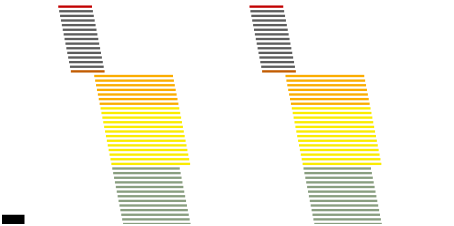

In [19]:
# spike rater plot
# colors in hex code
colors = Dict(
    "SA" => colorant"#C20000",
    "Atrial" => colorant"#5D5D5D",
    "AV" => colorant"#C25B00",
    "HIS" => colorant"#FBAD00",
    "Purkinje" => colorant"#FBEC00",
    "Ventricular" => colorant"#899E7F"
)
cm = 28.3465 # pt
fig = Figure(size = (8*cm, 4*cm), fontsize=10, figure_padding = 1, backgroundcolor = :transparent)
ax = Axis(fig[1,1]; xgridvisible = false, ygridvisible = false, backgroundcolor = :transparent)
hidedecorations!(ax)
hidespines!(ax)
N = maximum([ap[2] for ap in aps])
# set xlims
xlims!(ax, 0, 2.0)
ylims!(ax, 0, N)
for ap in aps
    time, index, type = ap
    index = N - index
    ts = [time,time+action_potential_durations[type]]
    band!(ts, ones(length(ts))*(index-0.25), ones(length(ts))*(index+0.25), color = colors[type])
end
# include a scale for the time
ts = [0, 0.1]
band!(ts, ones(length(ts))*0, ones(length(ts))*2, color = colorant"black")
# save as pdf
save("../figures/spike_rate_cardiomyocite_model.pdf", fig, pt_per_unit = 1)
fig